In [45]:
from spektral.layers import GraphConv
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.backend import gather, squeeze
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


## First trail

In [46]:
class GraphicEncoder():
    def __init__(self, F):
        self.model = self.build_model(F)

    def build_model(self,F):
        X_in = Input(shape=(F,), name='X_in')
        A_in = Input(shape=(None,), name='A_in')
        RL_indice = Input(shape=(None,),batch_size = 1, name='RL_indice',dtype='int32')

        
        ### Graphic convolution
        
        x = GraphConv(32, activation='relu',name='gcn1')([X_in, A_in])
        x = GraphConv(32, activation='relu',name='gcn2')([x, A_in])
        x = Lambda(lambda x: gather(x,RL_indice),name='slice')(x)
        
        x = Lambda(lambda x: squeeze(x,0),name='squeeze')(x)
        
        ### Policy network
        
        x = Dense(32,activation='relu',name='policy_1')(x)
        x = Dense(16,activation='relu',name='policy_2')(x)
        x = Dense(3, activation='relu',name='policy_3')(x)
        
        
        model = Model(inputs = [X_in,A_in,RL_indice], outputs=x)
        print(model.summary())
        return model
    
    
feature_size = 9
rl_model = GraphicEncoder(feature_size)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 9)]          0                                            
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn1 (GraphConv)                (None, 32)           320         X_in[0][0]                       
                                                                 A_in[0][0]                       
__________________________________________________________________________________________________
gcn2 (GraphConv)                (None, 32)           1056        gcn1[0][0]                 

In [6]:
from gym.spaces.box import Box
from gym.spaces import Discrete
from gym.spaces.dict import Dict
import numpy as np

In [7]:
from ray.rllib.models.tf.tf_modelv2 import TFModelV2

In [8]:
F = 9
N = 40

states = Box(low=-np.inf, high=np.inf, shape=(N,F), dtype=np.float32)
adjacency = Box(low=0, high=1, shape = (N,N), dtype=np.int32)
mask = Box(low=0, high=1, shape = (N,), dtype=np.int32)

obs_space = Dict({'states':states,'adjacency':adjacency,'mask':mask})
act_space = Box(low=0, high=1, shape = (N,), dtype=np.int32)

## Second trail

In [9]:
from spektral.layers import GraphConv
from tensorflow.keras.layers import Input, Dense, Lambda, Multiply, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

class GraphicPolicy(TFModelV2):
    def __init__(self, N,F, obs_space, action_space, num_outputs=3, model_config=None, name='graphic_policy'):
        super(GraphicPolicy,self).__init__(obs_space, action_space, num_outputs, model_config, name)
        self.base_model = self.build_model(N,F,num_outputs)
        self.register_variables(self.base_model.variables)
        
    def build_model(self,N,F,num_outputs):
        X_in = Input(shape=(N,F), name='X_in')
        A_in = Input(shape=(N,N), name='A_in')
        RL_indice = Input(shape=(N), name='mask')
        
        ### Graphic convolution
        
        x = GraphConv(32, activation='relu',name='gcn1')([X_in, A_in])
        x = GraphConv(32, activation='relu',name='gcn2')([x, A_in])

        
        ### Policy network
        
        x1 = Dense(32,activation='relu',name='policy_1')(x)
        x2 = Dense(16,activation='relu',name='policy_2')(x1)
        
    
        ###  Action and filter
        x3 = Dense(num_outputs, activation='relu',name='policy_3')(x2)
        mask = Reshape((N,1),name='expend_dim')(RL_indice)
        out = Multiply(name='filter')([x3,mask])
        
        
        #### Value out
        x2 = Flatten(name='flatten')(x2)
        value = Dense(1,activation='linear',name='value_out')(x2)
        

        model = Model(inputs = [X_in,A_in,RL_indice], outputs=[out,value])
        print(model.summary())
        return model
    
    def forward(self, input_dict, state, seq_lens):
        obs = input_dic['obs']
        model_out, self._value_out = self.base_model({X_in:obs['states'],A_in:obs['adjacency'],RL_indice:obs['mask']})        
        return model_out,state
        
    def value_function(self):
        return tf.reshape(self._value_out, [-1])
    
model_config = {}
rl_model = GraphicPolicy(N,F, obs_space, act_space)

W0522 12:43:45.736737 4542281152 deprecation.py:506] From /anaconda3/envs/flow/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 40, 9)]      0                                            
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, 40, 40)]     0                                            
__________________________________________________________________________________________________
gcn1 (GraphConv)                (None, 40, 32)       320         X_in[0][0]                       
                                                                 A_in[0][0]                       
__________________________________________________________________________________________________
gcn2 (GraphConv)                (None, 40, 32)       1056        gcn1[0][0]                 

## Test for the model + agents

In [12]:
training_data.keys()

dict_keys(['state', 'action', 'reward', 'done'])

In [13]:
len(training_data['state'])

2292

In [14]:
training_data['state'][300][1].shape

(40, 40)

In [15]:
fake_states = [[np.random.randn(5)+i*10,np.random.randn(5,5),np.ones(5)] for i in range(1,5)]
fake_rewards = [1,2,3,4]
fake_dones =[0,0,0,1]
fake_actions = [10,20,30,40]
fake_states

[[array([7.9153743 , 9.26159146, 9.3487723 , 9.50259114, 9.26878305]),
  array([[ 0.55876794, -1.29143597, -1.26157116,  0.0067175 ,  1.45762905],
         [-0.2496225 , -1.18113194, -0.64023985,  0.57572564,  1.38913569],
         [-0.36616133, -1.26427436, -1.58928474,  0.38834024,  0.86398796],
         [-1.65986307, -0.75061176, -0.32146263, -0.20712333, -0.20888431],
         [-0.95091533,  1.05943482, -0.57729136,  1.32082576, -1.13142716]]),
  array([1., 1., 1., 1., 1.])],
 [array([20.10301795, 19.64728766, 19.78042387, 19.75255329, 18.50074277]),
  array([[-0.94962712,  0.23880779, -0.47542062,  0.23625995, -1.07391709],
         [ 0.53429654,  2.26011716,  0.08702358, -0.38375872, -0.68397557],
         [-0.93602674,  1.1519039 , -0.32001743,  0.33319174, -0.18702573],
         [ 0.43104547, -2.31832133,  0.95753109,  1.36804541,  0.44852518],
         [ 0.18593171,  0.37139554, -1.65117117, -0.36697241,  0.84376992]]),
  array([1., 1., 1., 1., 1.])],
 [array([30.11406164, 29.

In [16]:

from agents.memory import CustomerSequentialMemory

In [17]:
memory_buffer = CustomerSequentialMemory(limit=5000, window_length=1)
for obs,a, r, temin in zip(training_data['state'],training_data['action'], training_data['reward'], training_data['done']):
    if isinstance(a,np.ndarray):
        memory_buffer.append(obs,a,r,temin)

In [18]:
# memory_buffer = CustomerSequentialMemory(limit=5000, window_length=1)
# for obs,a, r, temin in zip(fake_states,fake_actions,fake_rewards,fake_dones):

#     memory_buffer.append(obs,a,r,temin)

In [19]:
batch_experience = memory_buffer.sample(1)

state0_batch = []
reward_batch = []
action_batch = []
terminal1_batch = []
state1_batch = []
for e in batch_experience:
    state0_batch.append(e.state0)
    state1_batch.append(e.state1)
    reward_batch.append(e.reward)
    action_batch.append(e.action)
    terminal1_batch.append(0. if e.terminal1 else 1.)

In [20]:
batch_experience

[Experience(state0=[(array([[470.61819252,  62.71      ,   4.5906919 ,   1.        ,
           0.        ,   0.        ,   1.        ,   0.        ,
           0.        ],
        [456.78061509,  62.71      ,   4.62387143,   1.        ,
           0.        ,   0.        ,   1.        ,   0.        ,
           0.        ],
        [389.1536841 ,  62.71      ,   4.09758905,   1.        ,
           0.        ,   0.        ,   1.        ,   0.        ,
           0.        ],
        [352.81553793,  62.71      ,   4.07771398,   1.        ,
           0.        ,   0.        ,   1.        ,   0.        ,
           0.        ],
        [408.71363284,  62.71      ,   4.56308624,   1.        ,
           0.        ,   0.        ,   1.        ,   0.        ,
           0.        ],
        [332.53946644,  62.71      ,   3.92507733,   1.        ,
           0.        ,   0.        ,   1.        ,   0.        ,
           0.        ],
        [374.94099262,  65.91      ,   4.84403246,   0. 

In [21]:
from rl.processors import Processor
class Jiqian_MultiInputProcessor(Processor):
    """
    The multi input preprocessor for the model
    """
    def __init__(self, nb_inputs):
            self.nb_inputs = nb_inputs

    def process_state_batch(self, state_batch):
        input_batches = [[] for x in range(self.nb_inputs)]
        # print((state_batch))
        for state in state_batch:
            for observation in state:
                assert len(observation) == self.nb_inputs
                for idx,s in enumerate(observation):
                    input_batches[idx].append(s)

        rt = [np.array(x) for x in input_batches]

        return rt



Using TensorFlow backend.


In [22]:
processed = multi_input_processor.process_state_batch(state0_batch)

NameError: name 'multi_input_processor' is not defined

In [48]:
from tensorflow.keras.utils import plot_model

In [49]:
class GraphicQNetworkKeras():
    def __init__(self, N,F, obs_space, action_space, num_outputs=3, model_config=None, name='graphic_policy_keras'):
        self.obs_space = obs_space
        self.action_space = action_space
        self.num_outputs = num_outputs
        self.name = name
        self.base_model = self.build_model(N,F,num_outputs)

    def build_model(self,N,F,num_outputs):
        X_in = Input(shape=(N,F), name='X_in')
        A_in = Input(shape=(N,N), name='A_in')
        RL_indice = Input(shape=(N), name='mask')

        ### Graphic convolution

        x = GraphConv(32, activation='relu',name='gcn1')([X_in, A_in])
        x = GraphConv(32, activation='relu',name='gcn2')([x, A_in])

        ### Policy network
        x1 = Dense(32,activation='relu',name='policy_1')(x)
        x2 = Dense(16,activation='relu',name='policy_2')(x1)

        ###  Action and filter
        x3 = Dense(num_outputs, activation='linear',name='policy_3')(x2)
        mask = Reshape((N,1),name='expend_dim')(RL_indice)
        qout = Multiply(name='filter')([x3,mask])

        model = Model(inputs = [X_in,A_in,RL_indice], outputs=[qout])
        print(model.summary())
        return model
rl_model = GraphicQNetworkKeras(N,F, obs_space, act_space)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 40, 9)]      0                                            
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, 40, 40)]     0                                            
__________________________________________________________________________________________________
gcn1 (GraphConv)                (None, 40, 32)       320         X_in[0][0]                       
                                                                 A_in[0][0]                       
__________________________________________________________________________________________________
gcn2 (GraphConv)                (None, 40, 32)       1056        gcn1[0][0]                 

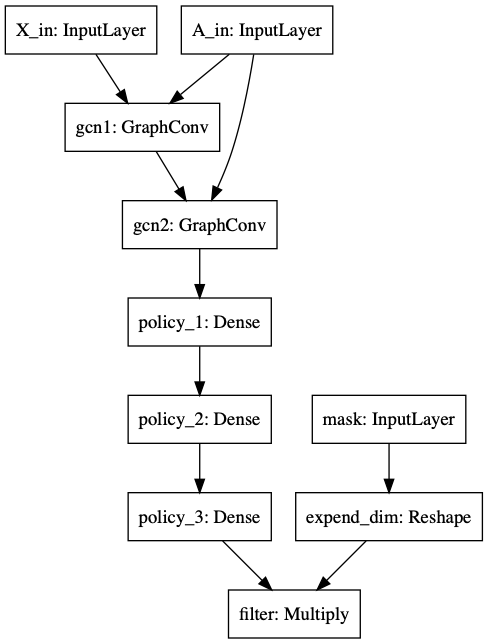

In [50]:
plot_model(rl_model.base_model)

In [ ]:
processed

In [ ]:
predicted = rl_model.base_model.predict(processed)

In [ ]:
predicted.shape

In [ ]:
predicted

In [ ]:
action_batch

In [ ]:
fake_true = np.ones([10,40,3])

In [ ]:
predicted.shape

In [24]:
from tensorflow.keras.losses import Huber
import tensorflow as tf
import sys
tf.__version__

'2.2.0'

In [25]:
from rl.policy import Policy
class greedy_q_policy(Policy):
    def select_action(self,q_vals):
        action = None
        mask = np.any(q_vals, axis=1)
        if mask.sum() > 0:
            action = q_vals[mask,:].argmax(1)
        return action

class random_obs_policy(Policy):
    def select_action(self,observation):
        action = None
        _,_,mask = observation
        num_agent = mask.sum().astype(int)
        if num_agent>0:
            action = np.random.choice(np.arange(3),num_agent)
        return action

class eps_greedy_q_policy(Policy):
    def __init__(self, eps=.1):
        super(eps_greedy_q_policy, self).__init__()
        self.eps = eps

    def select_action(self,q_vals):
        action = None
        mask = np.any(q_vals, axis=1)
        num_agent = mask.sum().astype(int)
        if num_agent>0:
            if np.random.uniform() < self.eps:  # choose random action
                action = np.random.choice(np.arange(3),num_agent)
            else:
                action = q_vals[mask,:].argmax(1)
        return action

## Assemble dqn

In [26]:
from agents.memory import CustomerSequentialMemory
memory_buffer = CustomerSequentialMemory(limit=5000, window_length=1)


for obs,a, r, temin in zip(training_data['state'],training_data['action'], training_data['reward'], training_data['done']):
    if isinstance(a,np.ndarray):
        memory_buffer.append(obs,a,r,temin)

In [27]:
test_policy = greedy_q_policy()
start_policy = random_obs_policy()
train_policy = eps_greedy_q_policy()

In [43]:
from agents.dqn import DQNAgent
multi_input_processor = Jiqian_MultiInputProcessor(3)
my_dqn = DQNAgent(processor= multi_input_processor,
                  model = rl_model.base_model, 
                  policy = train_policy,
                  test_policy=test_policy,
                  nb_total_agents = 40, 
                  nb_actions = 3, 
                  memory = memory_buffer,
                  nb_steps_warmup=10)

optimizer = tf.keras.optimizers.Adam(0.001)

my_dqn.compile(optimizer)

TypeError: __init__() got an unexpected keyword argument 'ragged'

In [42]:
import tensorflow as tf
# import tf.keras.callbacks.CallbackList
tf.__version__

'2.2.0'

In [41]:
tf.keras.callbacks.CallbackList

AttributeError: module 'tensorflow.keras.callbacks' has no attribute 'CallbackList'